<h1>Imports and API setups<h1>

In [264]:
from __future__ import print_function    # (at top of module)
import warnings
warnings.filterwarnings('always')
from spotipy.oauth2 import SpotifyClientCredentials
import json
import spotipy
import time
import sys
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline
import math
import seaborn as sns
import config


# Spotify API Setup
client_credentials_manager = SpotifyClientCredentials(config.client_id, config.client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Enables verbose requests tracing
sp.trace=False

## Read data from CSV

In [265]:
# Read the data from the file
data = pd.read_csv('file_path_big.csv')
data.head()
print("Number of entries in original data: " + str(len(data.index)))

Number of entries in original data: 441


## Clean the data

In [266]:
data = data.drop_duplicates(subset=['Song Title', 'Artist'], keep='first')
print("Number of entries in original data after cleaning: " + str(len(data.index)))

Number of entries in original data after cleaning: 441


## Analyzing the data

In [ ]:
sns.countplot(x="Mode", data=data)

In [ ]:
sns.countplot(x="Time Signature", data=data)

In [ ]:
sns.countplot(x="Key", data=data)

In [ ]:
data['Popularity'].plot.hist(bins=30, rwidth=10,figsize=(10,8))
plt.xlabel('Popularity')
plt.title("Popularity histogram")
plt.grid(alpha=0.3)

In [ ]:
sns.set_style('darkgrid')
sns.distplot(data["Popularity"])

## Label the data according to threshold for plotting

In [9]:
# Label data according to a threshold for nicer plotting
labeled_data = data.copy()
threshold = 70
labels = []

# The threshold is on Popularity, see above for description of that feature
for item in data['Popularity']:
    if item > threshold:
        labels.append(1)
    else:
        labels.append(0)
labeled_data['Is_Popular'] = labels

In [ ]:
sns.countplot(x="Is_Popular", hue = "Mode", data=labeled_data)

In [ ]:
sns.scatterplot(x="Popularity", y = "Duration in ms" , hue = "Is_Popular", data=labeled_data).set_title("Duration and popularity")

In [ ]:
sns.scatterplot(x="Popularity", y = "Instrumentalness" , hue = "Is_Popular", data=labeled_data).set_title("Instrumentalness and popularity")

In [ ]:
sns.scatterplot(x="Popularity", y = "Loudness" , hue = "Is_Popular", data=labeled_data).set_title("Loudness and popularity")

## Data wrangling

In [267]:
# Check if we have any null items in our data
data.isnull().sum()

Song Title          0
Artist              0
Popularity          0
Energy              0
Liveness            0
Tempo               0
Speechiness         0
Acousticness        0
Instrumentalness    0
Time Signature      0
Danceability        0
Key                 0
Duration in ms      0
Loudness            0
Valence             0
Mode                0
dtype: int64

# START HERE

## Setting popularity threshold and adding lables to data

In [269]:
# Make a copy of the data to which we will ad labels and then remove any 
# columns that we will not need
# This is currently a duplicate of the functionality above - could maybe only do this in one place

final_data = data.copy()
threshold = 90
labels = []
labeled_popular = 0
labeled_notpopular = 0
for item in data['Popularity']:
    if item > threshold:
        labels.append(1)
        labeled_popular = labeled_popular + 1
    else:
        labels.append(0)
        labeled_notpopular = labeled_notpopular + 1
final_data['Is_Popular'] = labels

print('Number of popular examples after thresholding : ', labeled_popular)
print('Number of not popular examples after thresholding : ', labeled_notpopular)

# Drop unnecessary columns from original data
final_data.drop(['Song Title', 'Artist', 'Popularity'], 1, inplace=True)

Number of popular examples after thresholding :  59
Number of not popular examples after thresholding :  382


## Scale the data

c:\python27\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  from ipykernel import kernelapp as app


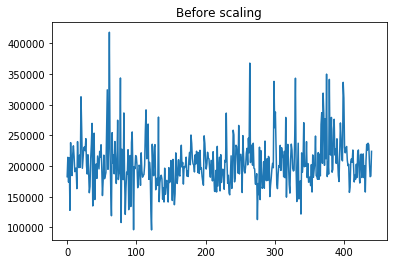

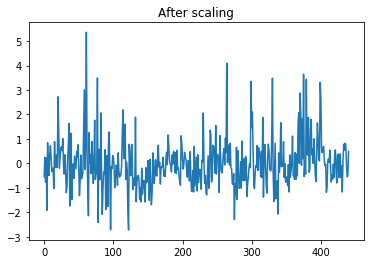

,Energy,Liveness,Tempo,Speechiness,Acousticness,Instrumentalness,Time Signature,Danceability,Key,Duration in ms,Loudness,Valence,Mode,Is_Popular
0,-0.753677,-0.455713,0.073642,0.583880,-0.770167,-0.130535,0.058124,2.059965,-1.150414,-0.540127,-0.501660,0.692417,0.858033,0
1,0.833382,-0.065400,-0.780769,-0.797869,-0.286706,-0.130535,0.058124,-0.119430,-0.036010,0.251132,1.495764,0.692417,0.858033,1
2,0.141745,-0.397166,-1.143120,1.729229,1.274783,-0.130535,0.058124,-1.080483,0.242591,-0.764371,-0.689448,-0.952450,-1.165456,1
3,0.685174,0.962424,0.005565,-0.851014,-1.055010,-0.130471,0.058124,0.591900,1.635597,0.226528,0.049662,-0.172072,0.858033,1
4,-0.833956,0.533080,-0.643045,1.811694,-1.057155,-0.130535,0.058124,1.499981,-0.871813,-1.914379,-0.982058,-0.905720,0.858033,1


In [270]:
from sklearn.preprocessing import scale, MinMaxScaler

COLUMNS_TO_SCALE = ["Energy", "Liveness", "Tempo", 
                    "Speechiness", "Acousticness", "Instrumentalness", 
                    "Time Signature", "Danceability", "Key", 
                    "Duration in ms", "Loudness", "Valence", "Mode"]

# Keep data in a temp variable for testing
scaled_data = final_data.copy()

# Normalization
#scaled_data[COLUMNS_TO_SCALE] = MinMaxScaler().fit_transform(scaled_data[COLUMNS_TO_SCALE])

#Standardization
scaled_data[COLUMNS_TO_SCALE] = scale(scaled_data[COLUMNS_TO_SCALE])

# Plots to see the difference before/after scaling
plt.plot(final_data['Duration in ms'])
plt.title("Before scaling")
plt.show()

plt.plot(scaled_data['Duration in ms'])
plt.title("After scaling")
plt.show()

# Copy data back
final_data = scaled_data.copy()

#Just to check that everything is fine
final_data.head()

## Extract labels from data

In [271]:
# X will be our examples and y will be our labels
X = final_data.drop('Is_Popular', axis=1)
y = final_data['Is_Popular']
# Sanity checks
print("Number of entries in actual data: " + str(len(X.index)))
print("Number of entries in label data: " + str(len(y.index)))

Number of entries in actual data: 441
Number of entries in label data: 441


## Splitting data

In [304]:
# We split the data into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
print("Items in training data set : ", str(len(X_train.index)))
print("Items in testing data set: ", str(len(X_test.index)))

Items in training data set :  220
Items in testing data set:  221


## Model training and prediction

In [334]:
# Initialize Logistic Regression Model
from sklearn.linear_model import LogisticRegression

# Can use the class_weight argument to assign different weights to the classes
# balanced - calculates the right weights according to the number of examples
# each class

logmodel = LogisticRegression(class_weight='balanced')
#logmodel = LogisticRegression()

print(logmodel)
# Train the model
logmodel.fit(X_train, y_train)

# Classifiy test examples
predictions = logmodel.predict(X_test)

# Print the accuracy score of the model
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


c:\python27\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.579185520361991

In [335]:
# Calculate k-fold cross validation score
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logmodel, X, y, cv=10, scoring='accuracy')
print(scores)
print(scores.mean())

[ 0.51111111  0.57777778  0.63636364  0.43181818  0.5         0.63636364
  0.59090909  0.63636364  0.25        0.48837209]
0.525907916373


c:\python27\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python27\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python27\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python27\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python27\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python27\lib\site-packages\sklea

In [306]:
# Print the classification report of the model
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.89      0.58      0.70       188
           1       0.19      0.58      0.29        33

   micro avg       0.58      0.58      0.58       221
   macro avg       0.54      0.58      0.50       221
weighted avg       0.78      0.58      0.64       221



In [307]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, predictions))

[[109  79]
 [ 14  19]]


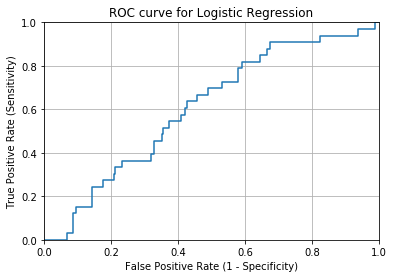

AUC score:  0.607350096712


In [308]:
# ROC curve
from sklearn.metrics import roc_curve
y_pred_prob = logmodel.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.plot([0,0],[1,1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Logistic Regression')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.show()


# AUC score
from sklearn.metrics import roc_auc_score
print("AUC score: ", roc_auc_score(y_test, y_pred_prob))

## K Nearest Neighbours

In [348]:
from sklearn.neighbors import KNeighborsClassifier
nbrs = KNeighborsClassifier(n_neighbors = 14)

nbrs.fit(X_train, y_train)

# Classifiy test examples
predictionsKNN = nbrs.predict(X_test)
accuracy_score(y_test, predictionsKNN)

0.85067873303167418

In [ ]:
# Looking for the best k value
k_range = list(range(1, 25))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

In [ ]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [349]:
# Calculate k-fold cross validation score
from sklearn.model_selection import cross_val_score
scores = cross_val_score(nbrs, X, y, cv=10, scoring='accuracy')
print(scores)
print(scores.mean())

[ 0.86666667  0.86666667  0.86363636  0.86363636  0.86363636  0.86363636
  0.86363636  0.86363636  0.86363636  0.88372093]
0.866250880902


In [351]:
print(classification_report(y_test, predictionsKNN))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       188
           1       0.00      0.00      0.00        33

   micro avg       0.85      0.85      0.85       221
   macro avg       0.43      0.50      0.46       221
weighted avg       0.72      0.85      0.78       221



c:\python27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [352]:
confusion_matrix(y_test, predictionsKNN)

array([[188,   0],
       [ 33,   0]], dtype=int64)

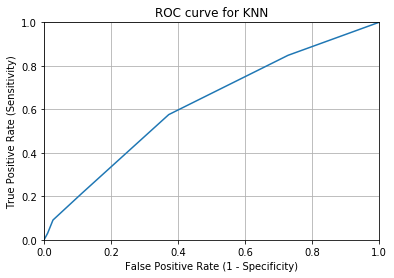

AUC score:  0.621212121212


In [353]:
# ROC curve
y_pred_prob_knn = nbrs.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_knn)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for KNN')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.show()


# AUC score
print("AUC score: ", roc_auc_score(y_test, y_pred_prob_knn))

Below I will use over-sampling with SMOTE(Synthetic Minority Oversampling Technique) to make up for the lack of examples of popular songs. This is one approach to fix the imbalanced class problem.

## Imbalanced Logistic Regression

In [313]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
classifier = LogisticRegression()
smote_pipeline = make_pipeline_imb(SMOTE(), classifier)
smote_model = smote_pipeline.fit(X_train, y_train)
predictionsLogImb = smote_model.predict(X_test)

c:\python27\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [314]:
from collections import Counter
X_smote, y_smote = SMOTE().fit_sample(X, y)
print("Normal data distribution: ", Counter(y))
print("SMOTE data distribution: ", Counter(y_smote))

Normal data distribution:  Counter({0L: 382, 1L: 59})
SMOTE data distribution:  Counter({0: 382, 1: 382})


In [315]:
print(classification_report_imbalanced(y_test, predictionsLogImb))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.62      0.48      0.72      0.55      0.30       188
          1       0.18      0.48      0.62      0.26      0.55      0.30        33

avg / total       0.77      0.60      0.50      0.65      0.55      0.30       221



In [316]:
print(confusion_matrix(y_test, predictionsLogImb))

[[116  72]
 [ 17  16]]


In [317]:
accuracy_score(y_test, predictionsLogImb)

0.59728506787330315

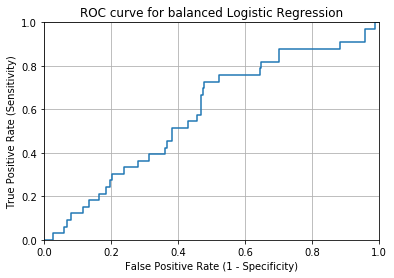

AUC score:  0.581399097357


In [318]:
# ROC curve
y_pred_prob_log_imb = smote_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_log_imb)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for balanced Logistic Regression')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.show()


# AUC score
print("AUC score: ", roc_auc_score(y_test, y_pred_prob_log_imb))

## Imbalanced KNN

In [359]:
classifierKNN = KNeighborsClassifier(n_neighbors = 5)
smote_pipeline_knn = make_pipeline_imb(SMOTE(), classifierKNN)
smote_model_knn = smote_pipeline_knn.fit(X_train, y_train)
predictionsKnnImb = smote_model_knn.predict(X_test)

In [360]:
print(classification_report_imbalanced(y_test, predictionsKnnImb))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.73      0.42      0.80      0.56      0.32       188
          1       0.22      0.42      0.73      0.29      0.56      0.30        33

avg / total       0.78      0.68      0.47      0.72      0.56      0.32       221



In [361]:
accuracy_score(y_test, predictionsKnnImb)

0.68325791855203621

In [362]:
print(confusion_matrix(y_test, predictionsKnnImb))

[[137  51]
 [ 19  14]]


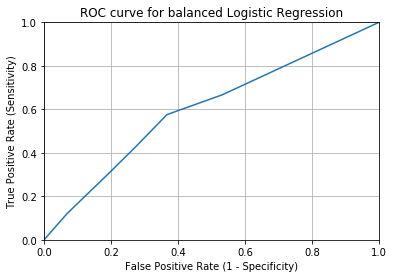

AUC score:  0.599532559639


In [363]:
# ROC curve
y_pred_prob_knn_imb = smote_model_knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_knn_imb)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for balanced Logistic Regression')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.show()


# AUC score
print("AUC score: ", roc_auc_score(y_test, y_pred_prob_knn_imb))